# 0 - Import & Load Data

In [2]:
## for data
import json
import pandas as pd
import numpy as np

# to compute cosine similarity
from sklearn import metrics, manifold


In [3]:
df_own_dict = pd.read_json('df_own_dict.json')
df_data_dict = pd.read_json('df_data_dict.json')
df_sentence = pd.read_json('df_sentence.json')
df_vader = pd.read_csv('df_vader.csv')

In [4]:
print(type(df_own_dict.iloc[0].embedding))
df_own_dict

<class 'list'>


,sentiment,embedding
0,positive_own,"[-0.23684903980000002, 0.11508918550000001, 0...."
1,negative_own,"[-0.45195508, 0.0403723456, 0.5418859124000001..."


In [5]:
df_data_dict

,sentiment,embedding
0,positive_data,"[-0.6036096215, 0.11336755750000001, 0.6376053..."
1,negative_data,"[-0.7820361257, 0.20127013330000001, 0.5900069..."


In [6]:
df_sentence.head(10)

,tweet,tweet_embedding
0,Real Estate Market would crash if there is no ...,"[0.2257416844, -0.0169709176, 0.6545215249, -1..."
1,"Concur. My company was 100% ""you MUST work in ...","[-0.3543173969, -0.3487285674, 0.2804761231000..."
2,Why not ask if we really need that thing ? I t...,"[-0.733558774, -0.3607640862, 0.1692087054, -0..."
3,Dear Line Managers Appraisal your subordinate ...,"[-0.6378751993, 0.2945272923, 0.22799032930000..."
4,I have had more opportunities to work cross-fu...,"[-0.2694126964, -0.3058058321, 0.7276366353, -..."
5,Study reveals growing cybersecurity risks driv...,"[-1.0207954645, -0.6177105904, 0.7027013302, -..."
6,As a remote employee you may be tempted to che...,"[-0.6545557976, 0.033209234500000004, 0.194388..."
7,I am lucky mine is moving to a hybrid model. S...,"[-0.6591749787, -0.9909458756, 0.4506825209, -..."
8,Shifting to a #remotework environment created ...,"[-0.4876919985, -0.2119547725, 0.6156088710000..."
9,professionals from a range of industries who n...,"[-0.7931020856000001, -0.4555655718, 0.8284254..."


In [7]:
df_vader = df_vader.drop(['VaderScore'],1)

In [8]:
df_vader.head(10)

,tweet,VaderSentiment
0,Real Estate Market would crash if there is no ...,NEGATIVE
1,"Concur. My company was 100% ""you MUST work in ...",NEGATIVE
2,Why not ask if we really need that thing? I th...,POSITIVE
3,"Dear Line Managers, Appraisal your subordinate...",POSITIVE
4,I have had more opportunities to work cross-fu...,POSITIVE
5,Study reveals growing cybersecurity risks driv...,NEGATIVE
6,"As a remote employee, you may be tempted to ch...",NEGATIVE
7,"I am lucky, mine is moving to a hybrid model. ...",POSITIVE
8,Shifting to a #remotework environment created ...,POSITIVE
9,professionals from a range of industries who n...,POSITIVE


<span style="background-color:Teal"> We need to compute the distance between: <span><br>
<span style="background-color:Teal"> 1. Using +ve and -ve words from our data: <br>
<span style="background-color:Teal"> a) tweet -> positive average embedding <span><br>
<span style="background-color:Teal"> b) tweet -> negative average embedding <span><br><span style="background-color:Teal"> b) tweet -> negative average embedding <span><br>

<span style="background-color:Teal"> 2. Using our own +ve and -ve words  <span><br>
<span style="background-color:Teal"> a) tweet -> positive average embedding <span><br>
<span style="background-color:Teal"> b) tweet -> negative average embedding <span><br>

# 1 - Distance between tweets and words clusters from our data

## 1.1 Convert sentence and word embedding as list

In [9]:
# 1. get sentence embedding as a list
sentence_embedding_list = df_sentence.tweet_embedding.to_list()

In [10]:
print(len(sentence_embedding_list[0]))
print(len(sentence_embedding_list))

768
3000


In [11]:
# 2. get word embedding as a list
data_embedding_list = df_data_dict.embedding.to_list()

In [12]:
print(len(data_embedding_list[0]))
print(len(data_embedding_list))

768
2


## 1.2 Loop through both list and compute distance

In [13]:
# 3. loop through the sentence embedding list and compute distance

data_distances_all_sentences = []

# 1. For each text:
for sentence_embedding in sentence_embedding_list:
    # create empty list of distance for each text
    distance_single_sentence = []
    
    for category_embedding in data_embedding_list:  
        # 2. compute distance to each of the 2 sentiments (positive + negative)
        # cosine_similarity takes two 2D array as an argument
        distance = metrics.pairwise.cosine_similarity([sentence_embedding], [category_embedding])
        # 3. insert distance to a list
        distance_single_sentence.append(distance[0][0])
    data_distances_all_sentences.append(distance_single_sentence)
        

In [14]:
print('number of distances: ',len(data_distances_all_sentences))

print('\nfirst distance: ', data_distances_all_sentences[0])

df_data_distance = pd.DataFrame(data_distances_all_sentences, columns=['POSITIVE', 'NEGATIVE'])



number of distances:  3000

first distance:  [0.6742946541338265, 0.6467679285861487]


In [15]:
df_data_distance

,POSITIVE,NEGATIVE
0,0.674295,0.646768
1,0.720249,0.662964
2,0.685892,0.721454
3,0.552029,0.649821
4,0.596510,0.636445
...,...,...
2995,0.271691,0.292918
2996,0.659252,0.588294
2997,0.678614,0.634783
2998,0.643832,0.713236


## 1.3 Adjust and Rescale

<span style="background-color:Teal">to make each row's sum of similarity to be equal to 1<span>

In [16]:
# create random number from 0 to 2
labels = ['POSITIVE', 'NEGATIVE']
print(labels)
print([0]*2)

# create random number 0-2
np.random.choice(range(2))

['POSITIVE', 'NEGATIVE']
[0, 0]


0

In [17]:
# for each row
for i in range(len(data_distances_all_sentences)):
    # sum this row 
    sum_row = sum(data_distances_all_sentences[i])
    
    # 1. if no similarity to any of the category assign randomly
    if(sum_row == 0):
        # assign 0 to each category
        data_distances_all_sentences[i] = [0]*len(labels)
        
        # get random index between 0-2
        random_index = np.random.choice(range(2))
        data_distances_all_sentences[random_index] = 1
        
    # 2. if not rescale so they sum == 1
    data_distances_all_sentences[i] = data_distances_all_sentences[i]/ sum_row

In [18]:
# check if each row no sums to 1
df_distance = pd.DataFrame(data_distances_all_sentences, columns=['POSITIVE', 'NEGATIVE'])
df_distance.head(7)

,POSITIVE,NEGATIVE
0,0.510418,0.489582
1,0.520707,0.479293
2,0.487365,0.512635
3,0.459316,0.540684
4,0.483805,0.516195
5,0.491955,0.508045
6,0.500108,0.499892


## 1.4 Classify tweet with highest similarity score

In [1]:
predicted =[]

# for each distance pair:
for row in data_distances_all_sentences:
    # 1. get the index with highest score . 
    # index 1 means negative, index 0 means positive
    prediction_index = np.argmax(row)

    # 2. get the name of our prediction
    prediction_name = labels[prediction_index]
    
    predicted.append(prediction_name)

NameError: name 'data_distances_all_sentences' is not defined

In [20]:
predicted[0:6]

['POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE']

In [21]:
# convert to dataframe
predicted_data_df = pd.DataFrame(predicted)

In [22]:
df_sentence['data_predicted'] = predicted_data_df.values

In [23]:
df_sentence

,tweet,tweet_embedding,data_predicted
0,Real Estate Market would crash if there is no ...,"[0.2257416844, -0.0169709176, 0.6545215249, -1...",POSITIVE
1,"Concur. My company was 100% ""you MUST work in ...","[-0.3543173969, -0.3487285674, 0.2804761231000...",POSITIVE
2,Why not ask if we really need that thing ? I t...,"[-0.733558774, -0.3607640862, 0.1692087054, -0...",NEGATIVE
3,Dear Line Managers Appraisal your subordinate ...,"[-0.6378751993, 0.2945272923, 0.22799032930000...",NEGATIVE
4,I have had more opportunities to work cross-fu...,"[-0.2694126964, -0.3058058321, 0.7276366353, -...",NEGATIVE
...,...,...,...
2995,I am available if a remote work opportunity ar...,"[-0.7216980457000001, -0.13284055890000002, -0...",NEGATIVE
2996,It made almost everyone work with limited reso...,"[-0.3001962602, -0.4217567742, 0.8289895058000...",POSITIVE
2997,I started moving things into my new office ups...,"[-0.5860046148, 0.10863680390000001, 0.7529717...",POSITIVE
2998,DYK that we have spent more than 5.5 billion m...,"[-0.5358973145, -0.4356870949, 0.8506852984000...",NEGATIVE


# 2 - Distance between tweets and words clusters from our data

## 2.1 Convert own word embedding as list

In [24]:
own_embedding_list = df_own_dict.embedding.to_list()

In [25]:
len(own_embedding_list)

2

## 2.2 Loop through sentence and word list to compute distance

In [26]:
# 3. loop through the sentence embedding list and compute distance
own_distances_all_sentences = []

# 1. For each text:
for sentence_embedding in sentence_embedding_list:
    # create empty list of distance for each text
    distance_single_sentence = []
    
    for category_embedding in own_embedding_list:  
        # 2. compute distance to each of the 2 sentiments (positive + negative)
        # cosine_similarity takes two 2D array as an argument
        distance = metrics.pairwise.cosine_similarity([sentence_embedding], [category_embedding])
 
        # 3. insert distance to a list
        distance_single_sentence.append(distance[0][0])
    own_distances_all_sentences.append(distance_single_sentence)

In [27]:
own_distances_all_sentences

[[0.318784492610498, 0.4524930891190722],
 [0.26059102251646576, 0.3697676735380847],
 [0.33324240498076957, 0.407575360588435],
 [0.17337913021864995, 0.18052438529731815],
 [0.4624976696998585, 0.21504063051968467],
 [0.3106496122648842, 0.27604817293322537],
 [0.2869455804813068, 0.4006379003945494],
 [0.38036508633747856, 0.15300123569229185],
 [0.28747559308107934, 0.322284901702829],
 [0.40488109797231575, 0.09917539884660083],
 [0.1326996919170143, 0.28371371573014587],
 [0.4905684911318522, 0.2369096311703943],
 [0.18632310207695382, 0.2530906892985063],
 [0.123433855745184, 0.4747190317173344],
 [0.09810009956112711, 0.4135555396226889],
 [0.23706931914898133, 0.445968119032811],
 [0.1907075878068408, 0.5124394359025687],
 [0.1512908728105473, 0.2572071755763475],
 [0.3359882995191506, 0.24940336526302956],
 [0.5297120691132773, 0.18123461832671262],
 [0.3122801440006717, 0.47531260603126924],
 [0.033242620257744625, 0.2845094799923896],
 [0.06197161114986675, 0.26363307812062

## 2.3 Adjust and Rescale

In [28]:
# for each row
for i in range(len(own_distances_all_sentences)):
    # sum this row 
    sum_row = sum(own_distances_all_sentences[i])
    
    # 1. if no similarity to any of the category assign randomly
    if(sum_row == 0):
        # assign 0 to each category
        own_distances_all_sentences[i] = [0]*len(labels)
        
        # get random index between 0-2
        random_index = np.random.choice(range(2))
        own_distances_all_sentences[random_index] = 1
        
    # 2. if not rescale so they sum == 1
    own_distances_all_sentences[i] = own_distances_all_sentences[i]/ sum_row

## 2.4 Classify tweet with highest similarity score

In [129]:
own_predicted =[]

# for each distance pair:
for row in own_distances_all_sentences:
    # 1. get the index with highest score . 
    # index 1 means negative, index 0 means positive
    prediction_index = np.argmax(row)

    # 2. get the name of our prediction
    prediction_name = labels[prediction_index]
    
    own_predicted.append(prediction_name)

In [30]:
# convert to dataframe
predicted_own_df = pd.DataFrame(own_predicted)

In [31]:
df_sentence['own_predicted'] = predicted_own_df.values

In [32]:
df_sentence

,tweet,tweet_embedding,data_predicted,own_predicted
0,Real Estate Market would crash if there is no ...,"[0.2257416844, -0.0169709176, 0.6545215249, -1...",POSITIVE,NEGATIVE
1,"Concur. My company was 100% ""you MUST work in ...","[-0.3543173969, -0.3487285674, 0.2804761231000...",POSITIVE,NEGATIVE
2,Why not ask if we really need that thing ? I t...,"[-0.733558774, -0.3607640862, 0.1692087054, -0...",NEGATIVE,NEGATIVE
3,Dear Line Managers Appraisal your subordinate ...,"[-0.6378751993, 0.2945272923, 0.22799032930000...",NEGATIVE,NEGATIVE
4,I have had more opportunities to work cross-fu...,"[-0.2694126964, -0.3058058321, 0.7276366353, -...",NEGATIVE,POSITIVE
...,...,...,...,...
2995,I am available if a remote work opportunity ar...,"[-0.7216980457000001, -0.13284055890000002, -0...",NEGATIVE,POSITIVE
2996,It made almost everyone work with limited reso...,"[-0.3001962602, -0.4217567742, 0.8289895058000...",POSITIVE,POSITIVE
2997,I started moving things into my new office ups...,"[-0.5860046148, 0.10863680390000001, 0.7529717...",POSITIVE,POSITIVE
2998,DYK that we have spent more than 5.5 billion m...,"[-0.5358973145, -0.4356870949, 0.8506852984000...",NEGATIVE,NEGATIVE


# 3 - Save Vader score into the df

In [65]:
df_merge = df_sentence.merge(df_vader, how = 'inner' ,indicator=False)

In [66]:
df_merge

,tweet,tweet_embedding,data_predicted,own_predicted,VaderSentiment
0,"Concur. My company was 100% ""you MUST work in ...","[-0.3543173969, -0.3487285674, 0.2804761231000...",POSITIVE,NEGATIVE,NEGATIVE
1,Study reveals growing cybersecurity risks driv...,"[-1.0207954645, -0.6177105904, 0.7027013302, -...",NEGATIVE,POSITIVE,NEGATIVE
2,Learn the top business functions to outsource ...,"[0.3671964109, 0.4819124937, 0.3259748816, -1....",NEGATIVE,POSITIVE,POSITIVE
3,Wrapping-up remote work for the day... just go...,"[-0.4098833501, -0.5858969688, 0.9731462598, -...",NEGATIVE,NEGATIVE,POSITIVE
4,Yup. And seeing an article yesterday trying to...,"[0.1640227735, -0.0528694689, 0.1988344491, -0...",NEGATIVE,NEGATIVE,POSITIVE
...,...,...,...,...,...
677,Freelancing is the answer to being a slave to ...,"[0.0466130301, -0.9194151759, -0.1806280911, -...",NEGATIVE,NEGATIVE,POSITIVE
678,Effective communication is key when it comes t...,"[-0.6447560191, -0.1380660683, 0.3176239431000...",POSITIVE,POSITIVE,POSITIVE
679,in the room we are putting the TV. Samsung wil...,"[-0.1216553077, -0.2701974809, 0.0527218617000...",POSITIVE,NEGATIVE,POSITIVE
680,do you ever have to wack the sky remote to get...,"[0.0159683842, -0.3788262606, 0.1322553605, -0...",POSITIVE,POSITIVE,NEUTRAL


# 4 - Print tweets and compare predictions

In [67]:
listString = ['POSITIVE', 'POSITIVE', 'POSITIVE']
listString.count(listString[0]) == len(listString)

True

In [68]:
count = 0
for i in range(len(df_merge)):
    sentiment_all_models = []
    sentiment_all_models.append(df_merge.iloc[i].data_predicted)
    sentiment_all_models.append(df_merge.iloc[i].own_predicted)
    sentiment_all_models.append(df_merge.iloc[i].VaderSentiment)

    are_same = sentiment_all_models.count(sentiment_all_models[0]) == len(sentiment_all_models)  
    if are_same and sentiment_all_models[0] == 'NEGATIVE':
        print(count)
        # 1. print tweets
        print(df_merge.iloc[i].tweet)
    
        # 2. print prediciton by data
        print('data prediction: ', df_merge.iloc[i].data_predicted)
    
        # 3. print prediciton by own cluster
        print('own prediction: ', df_merge.iloc[i].own_predicted)
        
         # 3. print Vader Prediction
        print('Vader prediction: ', df_merge.iloc[i].VaderSentiment)
    
        print('\n')
        count+=1

0
So are you telling me I should leave my eight-year-old at home by his se I have no babysitter he is remote learning and I can not go back to work so are you telling me I do not count what I need does not matter what my son need does not matter safety is first what is wrong with you all
data prediction:  NEGATIVE
own prediction:  NEGATIVE
Vader prediction:  NEGATIVE


1
I had a supervisor who hated that we had to work from home. He wanted us all to get hired full time by the state so we could have office parties. I reminded him that some of us could never have that happen. I live hours away from "the office " and without remote work I am home
data prediction:  NEGATIVE
own prediction:  NEGATIVE
Vader prediction:  NEGATIVE


2
I do not know why our company can not attract more diverse talent." #RemoteWork #WorkFromAnywhere #TalentAcquisition #Recruitment #DEI #HR
data prediction:  NEGATIVE
own prediction:  NEGATIVE
Vader prediction:  NEGATIVE


3
if you do not trust your people to get 

<span style="background-color:Teal">There are 1500 tweets out of 3000 with unmatched sentiment.<span>


<span style="background-color:Teal">Own prediction is better at:
#1332
#1333 
#1331
#1328
#1325
#8
<span>

<span style="background-color:Teal">Data prediction is better at:
#1330 #1326
<span>
<span style="background-color:Teal">Overall using our own embedded cluster gives better result<span>   
<span style="background-color:Teal">Let's save the negative tweets and use BERT again to extract topic<span>    

There are many negative tweet about remote work but are actually advocates of remote work. The tweets are negative because they are criticising compaies who don't allow them to do remote work

In [69]:
count = 0
for i in range(len(df_merge)):
    sentiment_all_models = []
#     sentiment_all_models.append(df_merge.iloc[i].data_predicted)
    sentiment_all_models.append(df_merge.iloc[i].own_predicted)
    sentiment_all_models.append(df_merge.iloc[i].VaderSentiment)

    are_same = sentiment_all_models.count(sentiment_all_models[0]) == len(sentiment_all_models)  
    if are_same and sentiment_all_models[0] == 'NEGATIVE':
        print(count)
        # 1. print tweets
        print(df_merge.iloc[i].tweet)
    
        # 2. print prediciton by data
        print('data prediction: ', df_merge.iloc[i].data_predicted)
    
        # 3. print prediciton by own cluster
        print('own prediction: ', df_merge.iloc[i].own_predicted)
        
        # 4. print Vader Prediction
        print('Vader prediction: ', df_merge.iloc[i].VaderSentiment)
    
        print('\n')
        count+=1

0
Concur. My company was 100% "you MUST work in the office" and now they have said that is gone. More importantly many of our leaders have moved remote and we have hired remotely. That is a genie that is REALLY hard to put back in the bottle.
data prediction:  POSITIVE
own prediction:  NEGATIVE
Vader prediction:  NEGATIVE


1
So weird how we all decided to never replace the batteries in the air conditioner remote and instead beat the sh*t out of it to make it work forever.
data prediction:  POSITIVE
own prediction:  NEGATIVE
Vader prediction:  NEGATIVE


2
Glad you exposed me to this. What bizarre arguments to bring forth against remote work from the Boston Globe.
data prediction:  POSITIVE
own prediction:  NEGATIVE
Vader prediction:  NEGATIVE


3
Any piece that tries to say why we should ditch remote work and move towards office again probably do not care about the disabled and neurodivergent
data prediction:  POSITIVE
own prediction:  NEGATIVE
Vader prediction:  NEGATIVE


4
So are y

<span style="background-color:Teal">Question:<span>

1. Many of the negatives comes from people complaining that their employers are not allowing remote work. It's capturing negative tweets that I don't want. So it's pointless to do topic extraction.

2. The real negative remarks about remote work is about cyber security, isolation

3. Can I stop here? I want to try finish the other things. 

4. How much do data scientiest actually spend time on presentation and story telling ? DO you do it? 

<span style="background-color:Teal"> Future work: <span>

1. Use supervised learning. trained bert on labelled data that is not related to remote work.
   Then make prediction on the test data (remote work tweets)
2. Make +ve and -ve sentence clustering. compare with above
    
    
- make word cloud


# 5 - Prepare data for topic creation

In [130]:
# 1. assign negative labels on tweets where own and vader are both negative

df_neg = df_merge.loc[(df_merge['own_predicted'] == 'NEGATIVE') & (df_merge['VaderSentiment'] == 'NEGATIVE')]

In [73]:
df_neg.reset_index(drop = True, inplace = True)

In [74]:
df_neg

,tweet,tweet_embedding,data_predicted,own_predicted,VaderSentiment
0,"Concur. My company was 100% ""you MUST work in ...","[-0.3543173969, -0.3487285674, 0.2804761231000...",POSITIVE,NEGATIVE,NEGATIVE
1,So weird how we all decided to never replace t...,"[0.3376812041, -0.1152411997, 0.530261457, 0.3...",POSITIVE,NEGATIVE,NEGATIVE
2,Glad you exposed me to this. What bizarre argu...,"[-0.5353716612, 0.3261777461, 0.2838433087, -0...",POSITIVE,NEGATIVE,NEGATIVE
3,Any piece that tries to say why we should ditc...,"[-0.2667962313, 0.4768332839, 0.48676985500000...",POSITIVE,NEGATIVE,NEGATIVE
4,So are you telling me I should leave my eight-...,"[-0.8893477321000001, -0.361951381, -0.2480771...",NEGATIVE,NEGATIVE,NEGATIVE
...,...,...,...,...,...
128,Yeah. A lot of boundaries have dissolved with ...,"[0.06808185580000001, -0.4628287554, 0.2636246...",NEGATIVE,NEGATIVE,NEGATIVE
129,Getting very tired of the corporate-sponsored ...,"[-0.21660083530000002, -0.0097534209, 0.465162...",NEGATIVE,NEGATIVE,NEGATIVE
130,Counter #2 Most people I know loathe their cow...,"[-0.2670706809, 0.0491347052, 0.39799004790000...",NEGATIVE,NEGATIVE,NEGATIVE
131,its funny bc the argument against remote work ...,"[-0.0675944909, 0.10974104700000001, 0.4871161...",POSITIVE,NEGATIVE,NEGATIVE


In [84]:
import numpy
neg_embedding = df_neg.tweet_embedding.to_list()
numpy.array(neg_embedding)

array([[-3.54317397e-01, -3.48728567e-01,  2.80476123e-01, ...,
        -7.56684661e-01,  3.46957713e-01, -4.30680960e-02],
       [ 3.37681204e-01, -1.15241200e-01,  5.30261457e-01, ...,
         7.77830780e-02,  2.27703825e-01, -1.10991955e+00],
       [-5.35371661e-01,  3.26177746e-01,  2.83843309e-01, ...,
         2.88594961e-01,  9.88709331e-01, -2.58680135e-01],
       ...,
       [-2.67070681e-01,  4.91347052e-02,  3.97990048e-01, ...,
         3.68963957e-01,  9.60660630e-03,  6.76279000e-05],
       [-6.75944909e-02,  1.09741047e-01,  4.87116188e-01, ...,
        -4.29864861e-02,  3.22923481e-01, -1.37017772e-01],
       [-6.88116491e-01, -2.32450485e-01,  3.33814800e-01, ...,
        -3.18166196e-01,  1.00007856e+00,  2.17428014e-01]])

In [85]:
# 2. Lower dimensionality
import umap

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(neg_embedding)


In [86]:
umap_embeddings

array([[3.251263  , 5.645298  , 5.311782  , 6.571261  , 1.9475632 ],
       [3.5008283 , 5.1257195 , 4.4767284 , 7.5829906 , 1.1718808 ],
       [4.0287437 , 4.4206357 , 5.7093554 , 6.377043  , 1.1803029 ],
       [4.7731557 , 4.530677  , 5.749356  , 6.5448885 , 0.7707721 ],
       [3.926194  , 5.3822327 , 5.124051  , 7.557556  , 0.70562226],
       [5.152096  , 4.62684   , 5.8527513 , 6.6254106 , 0.69291425],
       [3.4046593 , 5.9687843 , 5.1080217 , 6.663255  , 1.5514821 ],
       [4.922811  , 4.7968698 , 5.467844  , 7.5585423 , 0.49382767],
       [4.8651752 , 4.57202   , 5.59487   , 6.195693  , 1.8775955 ],
       [5.104442  , 4.709876  , 5.530752  , 7.4041963 , 0.48382375],
       [5.1472025 , 4.737901  , 5.5458164 , 6.2620087 , 1.7839069 ],
       [3.4991562 , 4.344252  , 5.415529  , 6.8377213 , 1.9685327 ],
       [3.8249192 , 4.4683905 , 6.0498886 , 6.523744  , 2.5607915 ],
       [4.7550135 , 4.949324  , 4.4124823 , 6.8711557 , 1.1109709 ],
       [5.5795617 , 4.831157  , 5.

In [87]:
# 3. cluster
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [90]:
# 4. Visualize the cluser

import matplotlib.pyplot as plt

# Prepare data
# further reduce dimension to two
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(neg_embedding)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_
result['labels'] 

0      1
1     -1
2     -1
3      0
4     -1
      ..
128    1
129    0
130   -1
131    0
132   -1
Name: labels, Length: 133, dtype: int64

There are 3 clusters, -1,0,1

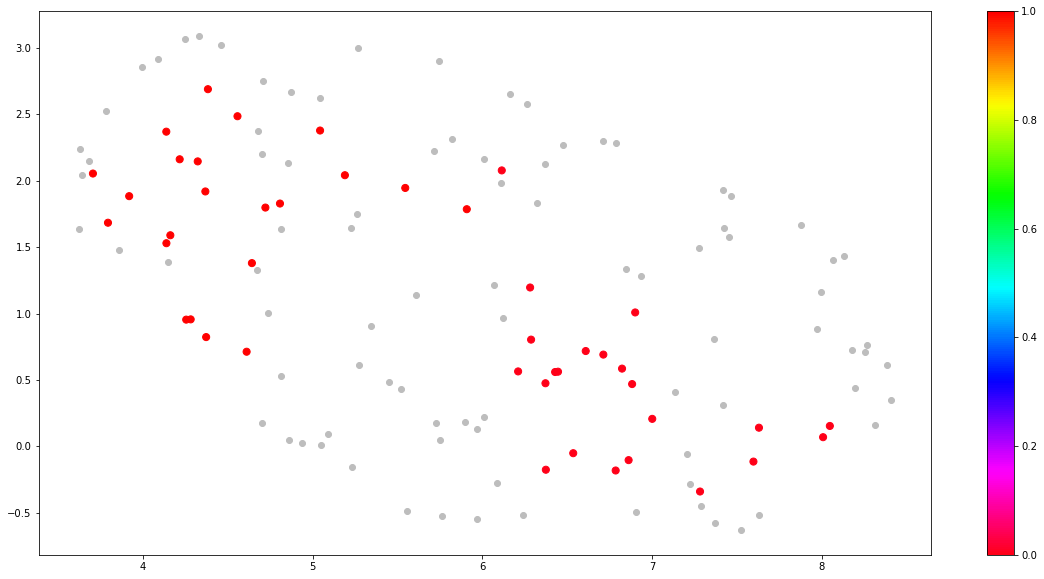

In [106]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels,s = 50, cmap='hsv_r')
plt.colorbar()


# 6. Topic creation

What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?

    How can we derive topics from clustered documents?

To solve this, I came up with a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

## 6.1 c-TF-IDF

In [110]:
df_neg['Topic'] = cluster.labels_

<ipython-input-110-0107201d15b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['Topic'] = cluster.labels_


In [113]:
df_neg['Doc_ID'] = range(len(df_neg))

<ipython-input-113-189c07ee97d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['Doc_ID'] = range(len(df_neg))


In [114]:
df_neg

,tweet,tweet_embedding,data_predicted,own_predicted,VaderSentiment,Topic,Doc_ID
0,"Concur. My company was 100% ""you MUST work in ...","[-0.3543173969, -0.3487285674, 0.2804761231000...",POSITIVE,NEGATIVE,NEGATIVE,1,0
1,So weird how we all decided to never replace t...,"[0.3376812041, -0.1152411997, 0.530261457, 0.3...",POSITIVE,NEGATIVE,NEGATIVE,-1,1
2,Glad you exposed me to this. What bizarre argu...,"[-0.5353716612, 0.3261777461, 0.2838433087, -0...",POSITIVE,NEGATIVE,NEGATIVE,-1,2
3,Any piece that tries to say why we should ditc...,"[-0.2667962313, 0.4768332839, 0.48676985500000...",POSITIVE,NEGATIVE,NEGATIVE,0,3
4,So are you telling me I should leave my eight-...,"[-0.8893477321000001, -0.361951381, -0.2480771...",NEGATIVE,NEGATIVE,NEGATIVE,-1,4
...,...,...,...,...,...,...,...
128,Yeah. A lot of boundaries have dissolved with ...,"[0.06808185580000001, -0.4628287554, 0.2636246...",NEGATIVE,NEGATIVE,NEGATIVE,1,128
129,Getting very tired of the corporate-sponsored ...,"[-0.21660083530000002, -0.0097534209, 0.465162...",NEGATIVE,NEGATIVE,NEGATIVE,0,129
130,Counter #2 Most people I know loathe their cow...,"[-0.2670706809, 0.0491347052, 0.39799004790000...",NEGATIVE,NEGATIVE,NEGATIVE,-1,130
131,its funny bc the argument against remote work ...,"[-0.0675944909, 0.10974104700000001, 0.4871161...",POSITIVE,NEGATIVE,NEGATIVE,0,131


In [116]:
docs_per_topic = df_neg.groupby(['Topic'], as_index = False).agg({'tweet': ' '.join})

In [119]:
print(docs_per_topic.iloc[0].tweet)

So weird how we all decided to never replace the batteries in the air conditioner remote and instead beat the sh*t out of it to make it work forever. Glad you exposed me to this. What bizarre arguments to bring forth against remote work from the Boston Globe. So are you telling me I should leave my eight-year-old at home by his se I have no babysitter he is remote learning and I can not go back to work so are you telling me I do not count what I need does not matter what my son need does not matter safety is first what is wrong with you all Lmaoooo not this organization trying to talk negatively about remote work. because they know they are wrong. EMBRACE THE FUTURE B WeWork is literally the dumbest idea of all the incredibly dumb things we come up that should never exist. it is literally just remote work that you do not need an office to do but instead of just doing that you have to go in to a fake office and do it I do not know why our company can not attract more diverse talent." #R

In [120]:
docs_per_topic

,Topic,tweet
0,-1,So weird how we all decided to never replace t...
1,0,Any piece that tries to say why we should ditc...
2,1,"Concur. My company was 100% ""you MUST work in ..."


Then, we apply the class-based TF-IDF:

In [122]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.tweet.values, m=len(df_neg))

# 7. Topic Representation

In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [127]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)


In [128]:
top_n_words

{-1: [('people', 0.024673416936457904),
  ('office', 0.02339042819188127),
  ('remotework', 0.023272092373428272),
  ('working', 0.021068925236038746),
  ('just', 0.019030361780274688),
  ('need', 0.018212169405819337),
  ('know', 0.01742271585305586),
  ('make', 0.016632589269478804),
  ('time', 0.016602443232524),
  ('got', 0.015715585759900418),
  ('want', 0.015312213226199457),
  ('way', 0.014933756445476452),
  ('lot', 0.01474824766522712),
  ('new', 0.01309632146658368),
  ('thing', 0.01309632146658368),
  ('wfh', 0.01309632146658368),
  ('does', 0.012444797037897044),
  ('hard', 0.011880420906770576),
  ('learning', 0.011848029643624221),
  ('workplace', 0.011848029643624221)],
 0: [('workers', 0.038508393381364706),
  ('communication', 0.03385479321030039),
  ('person', 0.031286203277695206),
  ('article', 0.031286203277695206),
  ('disagree', 0.031286203277695206),
  ('pandemic', 0.03080671470509176),
  ('companies', 0.02929385014096119),
  ('culture', 0.02929385014096119),
  